In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
# ### --- Config --- ###
# # dataset
# target_rotation_deg = 45.

# init_rotation_deg = 310.
# # training
# batch_size = 64
# epochs = 1
# lr=50
# # momentum=0.9
# scheduler_iters = 10

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # paths:
# run_name = f'init-{init_rotation_deg}_target-{target_rotation_deg}'

# figures_dir = f'figures'
# run_figures_dir = f'{figures_dir}/{run_name}'

# gifs_dir = f'gifs'
# run_gif_name = f'{gifs_dir}/{run_name}.gif'

# os.makedirs(run_figures_dir, exist_ok=True)
# os.makedirs(gifs_dir, exist_ok=True)

In [3]:
### --- Config --- ###
# dataset
target_rotation_deg = 100.

init_rotation_deg = 0.
# training
batch_size = 64
epochs = 1
lr=20
# momentum=0.9
scheduler_iters = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# paths:
run_name = f'init-{init_rotation_deg}_target-{target_rotation_deg}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)

In [4]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.RandomRotation(degrees=[target_rotation_deg,target_rotation_deg], p=1), # nn.Module
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    target_augmentations
])

In [5]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

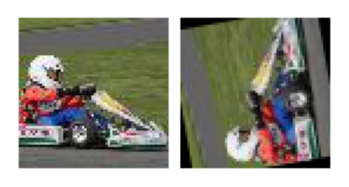

In [6]:
show_sample(dataset[0])

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [8]:
class AugmentationNetwork(nn.Module):
    def __init__(self, init_rot_degree):
        super().__init__()
        self.trans_param = Parameter(torch.Tensor([init_rot_degree]))

    def forward(self, x):
        clamped_param = torch.clamp(self.trans_param, min=-360.0, max=360.0)
        # clamped_param = torch.remainder(self.trans_param, 360.0)
        rand_rotation = K.augmentation.RandomRotation(
                        torch.cat([clamped_param, clamped_param]), p=1) # torch cat prevernts parameter from casting to float.
        out = rand_rotation(x)
        return out

In [9]:
model = AugmentationNetwork(init_rot_degree=init_rotation_deg)
model.to(device)

AugmentationNetwork()

In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

trans_param tensor([0.], device='cuda:0')


In [11]:
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93, last_epoch=-1, verbose=False)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.1, verbose=True)

Adjusting learning rate of group 0 to 2.0000e+01.


In [12]:
losses = []
lrs = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | {model.trans_param.item()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0]).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        lrs.append(scheduler.get_last_lr())
        if i % scheduler_iters == scheduler_iters - 1 and i > 100:
            scheduler.step()


        if i == 1000:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.099 | 54.370758056640625]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.059 | 101.06806182861328]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.022 | 98.00361633300781]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.008 | 97.81428527832031]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.003 | 100.36260223388672]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.001 | 100.46467590332031]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.000 | 99.59026336669922]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.000 | 100.2667236328125]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.000 | 99.69512939453125]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.000 | 99.8934097290039]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.000 | 100.28804016113281]
Adjusting learning rate of group 0 to 1.9995e+01.
[Epoch: 1 | Batch: 120 | MSE Loss: 0.000 | 100.17741394042969]
Adjusting learning rate of group 0 to 1.9980e+01.
[Epoch: 1 | Batch: 130 | MSE Loss: 0.000 | 99.74027252197266]
Adjusting learning rate of group 0 to 1.9956e+01.
[Epoch: 1 | Batch: 140 | MSE Loss: 0.000 | 99.78

In [13]:
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)

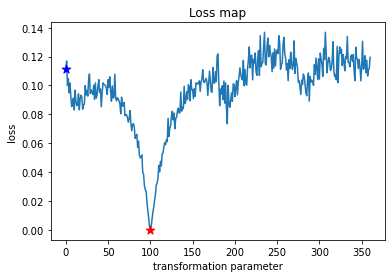

In [14]:
loss_map = create_loss_map(AugmentationNetwork, np.linspace(0,360,361),
                           dataloader, criterion,
                           save=run_name)
final_param = int(model.trans_param.item() % 360)
statring_point = int(init_rotation_deg)
plt.plot(loss_map, zorder=0)
plt.scatter([statring_point], y=[loss_map[statring_point]], marker='*', c='b', s=80, zorder=1)
plt.scatter([final_param], y=[loss_map[final_param]], marker='*', c='r', s=80, zorder=1)
plt.title('Loss map')
plt.xlabel('transformation parameter')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/loss_map.png')

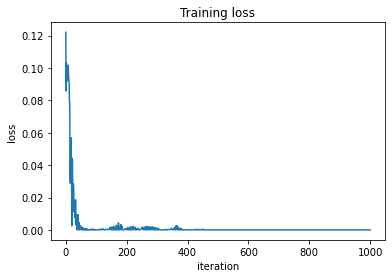

In [15]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

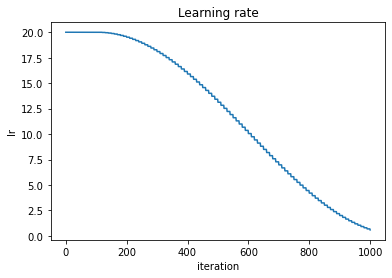

In [16]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [17]:
# filepaths
fp_in = f"{run_figures_dir}/epoch-*"
fp_out = run_gif_name

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)

In [18]:
fp_out

'gifs/init-0.0_target-100.0.gif'